In this notebook, we create a trading strategy that takes into account the news sentiments toward companies.
We use a database of more than 9,000 headlines that we evaluate with VADER Lexicon.
The strategy is based on two signal: change in sentiments toward a stock and momentum signal. 
Backtests of the strategy actually show profits.

In [2]:
import numpy as np
import csv
import pandas as pd
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import date

In [3]:
# read data from previous step
data_df = pd.read_csv(r'Data\Step4_DataWithSentimentsResults.csv', sep='|')
data_df = data_df.dropna()

In [4]:
data_df

,ticker,headline,date,eventRet,Close,sentiment_lex
0,AMZN,Whole Foods (WFMI) -5.2% following a downgrade...,2011-05-02,0.017650,10.059500,0.2115
1,NFLX,Netflix (NFLX +1.1%) shares post early gains a...,2011-05-02,-0.012912,33.884285,0.8575
2,MSFT,The likely winners in Microsoft's (MSFT -1.4%)...,2011-05-10,-0.019817,20.120020,0.6971
3,MSFT,Microsoft (MSFT -1.2%) and Skype signed their ...,2011-05-10,-0.019817,20.120020,0.7751
4,AMZN,Amazon.com (AMZN -1.7%) shares slip as comment...,2011-05-12,-0.006607,10.303500,-0.0413
...,...,...,...,...,...,...
2630,TSLA,Morgan Stanley sees the rally in Tesla (NASDAQ...,2018-12-18,-0.092015,22.468666,0.3717
2631,TSLA,"Responding to a comment on Twitter, Elon Musk ...",2018-12-24,0.041608,19.692667,0.6713
2632,AMZN,Amazon (NASDAQ:AMZN) is among the companies th...,2018-12-24,0.013062,67.197998,0.6419
2633,AAPL,Chinese companies urge employees to boycott (N...,2018-12-24,0.005652,35.375179,-0.5961


In [5]:
tickers = ['AAPL','MSFT','AMZN','GOOG','BA','WMT','JPM','TSLA','NFLX','ADBE']
# read return data from previous step
return_df = pd.read_csv(r'Data\Step2.2_ReturnData.csv')

In [6]:
# convert date format to YYYY-mm-dd
return_df['date']=return_df['Date'].apply(lambda x:datetime.strptime(x, '%Y-%m-%d %H:%M:%S%z').strftime('%Y-%m-%d'))
return_df= return_df.drop('Date', axis=1)

In [7]:
# calculate 15 days moving average of close price
return_df['moving_avg']=return_df.groupby('ticker')['Close'].rolling(20).mean().reset_index(level=0, drop=True)

In [8]:
return_df.head(20)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,date,moving_avg
0,6.487648,6.520173,6.455731,6.505279,493729600,0.0,0.0,AAPL,2010-01-04,NaN
1,6.523214,6.553307,6.482178,6.516527,601904800,0.0,0.0,AAPL,2010-01-05,NaN
2,6.516528,6.542365,6.406186,6.412874,552160000,0.0,0.0,AAPL,2010-01-06,NaN
3,6.436584,6.444184,6.354512,6.401019,477131200,0.0,0.0,AAPL,2010-01-07,NaN
4,6.392506,6.444181,6.354814,6.443573,447610800,0.0,0.0,AAPL,2010-01-08,NaN
5,6.468500,6.474580,6.336273,6.386733,462229600,0.0,0.0,AAPL,2010-01-11,NaN
6,6.358765,6.376396,6.274566,6.314082,594459600,0.0,0.0,AAPL,2010-01-12,NaN
7,6.318643,6.411658,6.204046,6.403146,605892000,0.0,0.0,AAPL,2010-01-13,NaN
8,6.386732,6.397371,6.353599,6.366062,432894000,0.0,0.0,AAPL,2010-01-14,NaN
9,6.411658,6.432024,6.257849,6.259673,594067600,0.0,0.0,AAPL,2010-01-15,NaN


In [9]:
# merge moving average into data_df
data_df=pd.merge(data_df, return_df[['ticker', 'date', 'moving_avg']], on=['ticker', 'date'], how='left')

In [10]:
data_df['sentiment_diff']=data_df.groupby('ticker')['sentiment_lex'].diff()

In [42]:
data_df[(data_df['date']>=begin_date)&(data_df['date']<=end_date)]

,ticker,headline,date,eventRet,Close,sentiment_lex,moving_avg,sentiment_diff,signal,profit,cash,position
0,AMZN,Whole Foods (WFMI) -5.2% following a downgrade...,2011-05-02,0.017650,10.059500,0.2115,9.281475,NaN,0,0.000000,100000,0
1,NFLX,Netflix (NFLX +1.1%) shares post early gains a...,2011-05-02,-0.012912,33.884285,0.8575,34.022071,NaN,0,0.000000,100000,0
2,MSFT,The likely winners in Microsoft's (MSFT -1.4%)...,2011-05-10,-0.019817,20.120020,0.6971,20.185468,NaN,0,0.000000,100000,0
3,MSFT,Microsoft (MSFT -1.2%) and Skype signed their ...,2011-05-10,-0.019817,20.120020,0.7751,20.185468,0.0780,0,0.000000,100000,0
4,AMZN,Amazon.com (AMZN -1.7%) shares slip as comment...,2011-05-12,-0.006607,10.303500,-0.0413,9.633725,-0.2528,0,0.000000,100000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
758,AMZN,Amazon (AMZN -6.9%) is giving back most of its...,2013-04-26,-0.070278,12.740500,0.9732,13.210100,0.5892,0,2603.151035,73300,2300
759,TSLA,Shares of Tesla Motors (TSLA +5.6%) rally agai...,2013-04-29,0.040371,3.662667,0.8866,3.064200,-0.0644,0,3188.934294,93666,2600
760,AAPL,"As Apple (AAPL +2.5%) surges above $425, a Fre...",2013-04-29,0.082000,13.267377,0.9756,12.898369,0.2567,1,-5897.180851,47667,3500
761,MSFT,LinkedIn (LNKD): Q1 EPS of $0.45 beats by $0.1...,2013-05-02,0.011919,27.500311,0.4404,25.230877,-0.1502,0,4112.373077,71112,1200


In [14]:
# signal is the actions we will take, 0=no action, 1=buy, -1=sell. Default=0
# set initial profit of each stock = 0
data_df['signal']=0
data_df['profit']=0
data_df['cash']=0
data_df['position']=0


In [15]:
# set the period we would like to obtain our parameters
begin_date='2011-05-02'
end_date='2013-05-03'

In [16]:
initial_capital=100000
transaction_cost=0.001 # 0.1% transaction cost for each transaction
unit=100 # the number of stocks we buy/sell per time

In [17]:
# use to modify signal, if close > ma we should not sell it, if close < ma, we will not buy it
def update_signal(row):
    if row['signal'] == 1 and row['Close'] < row['moving_avg']:
        return 0
    elif row['signal'] == -1 and row['Close'] > row['moving_avg']:
        return 0
    elif row['signal'] == 1 and row['Close'] >= row['moving_avg']:
        return 1
    elif row['signal'] == -1 and row['Close'] <= row['moving_avg']:
        return -1
    else:
        return row['signal']

In [19]:
# here we decide to use VADER as our main sentiment score
# create a funtion to calcuate the average profit 
def Profit(positive,negative,begin_date,end_date):
    # pass transaction signals to the stocks according to the sentiment score
    data_df['signal']=data_df['sentiment_diff'].apply(lambda x:1 if x >=positive else -1 if x<=negative else 0)
    
    data_df['signal'] = data_df.apply(update_signal, axis=1)
            
    # extract the period we want to check
    df=data_df[(data_df['date']>=begin_date)&(data_df['date']<=end_date)]
    
    # set initial parameters
    
    cash=np.full(10, initial_capital) # each ticker has 100000 cash intially
    profit=np.zeros(10) # initial profit = 0 for all stocks
    position=np.zeros(10) # number of stocks we hold
    end_price=np.zeros(10) # close price of the end date
    
    # trade
    for i,row in df.iterrows():
        for j in range(10):
            tick=tickers[j]
            if row.ticker== tick and cash[j]>=0:
                
                cash[j]=cash[j]-row.signal*unit*row.Close-abs(row.signal)*unit*row.Close*transaction_cost
                position[j]=position[j]+row.signal*unit
                profit[j]=cash[j]+position[j]*row.Close-initial_capital
                data_df.at[i,'profit']=profit[j]
                data_df.at[i,'cash']=cash[j]
                data_df.at[i,'position']=position[j]
            else:
                if row.ticker== tick and cash[j]<0:
                    cash[j]=cash[j]
                    position[j]=position[j]
                    profit[j]=cash[j]+position[j]*row.Close-initial_capital
                    data_df.at[i,'profit']=profit[j]
                    data_df.at[i,'cash']=cash[j]
                    data_df.at[i,'position']=position[j]
   


    # pass final value of holding stocks
    for i in range(10):
        tick=tickers[i]
        close=return_df.loc[(return_df['date']==end_date)&(return_df['ticker']==tick)]
        value = close.loc[close.index[0], 'Close']     
        end_price[i]=value
    
    # calcuate average profit
    profit=np.mean(cash+end_price*position-initial_capital)
    
    return profit

In [20]:
results=[]
for i in range(0,10):
    for j in range(-10,0):
        # set initial parameters
        
        cash=np.full(10, initial_capital) # each ticker has 100000 cash intially
        profit=np.zeros(10) # initial profit = 0 for all stocks
        position=np.zeros(10) # number of stocks we hold
        end_price=np.zeros(10) # close price of the end date
    
        positive=i/10
        negative=j/10
        
        profit=Profit(positive,negative,begin_date,end_date)
        results.append([positive,negative,profit])
    

In [27]:
# locate the max vlaue and parameters based on the begin date and end date
results=np.array(results)
max_value = np.max(results)
max_indices = np.where(results == max_value)
print(max_value)
print(max_indices)

10794.29113483429
(array([0], dtype=int64), array([2], dtype=int64))


In [28]:
results[0,:]

array([ 0.00000000e+00, -1.00000000e+00,  1.07942911e+04])

In [29]:
def strategy(positive,negative,begin_date,end_date):
    # pass transaction signals to the stocks according to the sentiment score
    data_df['signal']=data_df['sentiment_diff'].apply(lambda x:1 if x >=positive else -1 if x<=negative else 0)
    data_df['signal'] = data_df.apply(update_signal, axis=1)

            
    # extract the period we want to check
    df=data_df[(data_df['date']>=begin_date)&(data_df['date']<=end_date)]
    
    # set initial parameters
    
    cash=np.full(10, initial_capital) # each ticker has 100000 cash intially
    profit=np.zeros(10) # initial profit = 0 for all stocks
    position=np.zeros(10) # number of stocks we hold
    end_price=np.zeros(10) # close price of the end date
    
    # trade
    for i,row in df.iterrows():
        for j in range(10):
            tick=tickers[j]
            
            if row.ticker== tick and cash[j]>=0:
                
                cash[j]=cash[j]-row.signal*unit*row.Close-abs(row.signal)*unit*row.Close*transaction_cost
                position[j]=position[j]+row.signal*unit
                profit[j]=cash[j]+position[j]*row.Close-initial_capital
                data_df.at[i,'profit']=profit[j]
                data_df.at[i,'cash']=cash[j]
                data_df.at[i,'position']=position[j]
            else:
                if row.ticker== tick and cash[j]<0:
                    cash[j]=cash[j]
                    position[j]=position[j]
                    profit[j]=cash[j]+position[j]*row.Close-initial_capital
                    data_df.at[i,'profit']=profit[j]
                    data_df.at[i,'cash']=cash[j]
                    data_df.at[i,'position']=position[j]
    # pass final value of holding stocks
    for i in range(10):
        tick=tickers[i]
        close=return_df.loc[(return_df['date']==end_date)&(return_df['ticker']==tick)]
        value = close.loc[close.index[0], 'Close']     
        end_price[i]=value
    
    # calcuate average profit
    profit=cash+end_price*position-initial_capital
    
    return profit, position, cash,end_price,df

In [44]:
strategy(0,-1,begin_date,end_date)[0]

array([-3753.09305954,  4437.18782043,  2975.75035095, 11874.3077774 ,
       17862.70874023,  9715.97254944, 11501.31585693,  3121.33423424,
       43018.42791748,  7188.99916077])

In [45]:
df=strategy(0,-1,begin_date,end_date)[4]
df=df.reset_index(level=0,drop=True)

In [46]:
df

,ticker,headline,date,eventRet,Close,sentiment_lex,moving_avg,sentiment_diff,signal,profit,cash,position
0,AMZN,Whole Foods (WFMI) -5.2% following a downgrade...,2011-05-02,0.017650,10.059500,0.2115,9.281475,NaN,0,0.000000,100000,0
1,NFLX,Netflix (NFLX +1.1%) shares post early gains a...,2011-05-02,-0.012912,33.884285,0.8575,34.022071,NaN,0,0.000000,100000,0
2,MSFT,The likely winners in Microsoft's (MSFT -1.4%)...,2011-05-10,-0.019817,20.120020,0.6971,20.185468,NaN,0,0.000000,100000,0
3,MSFT,Microsoft (MSFT -1.2%) and Skype signed their ...,2011-05-10,-0.019817,20.120020,0.7751,20.185468,0.0780,0,0.000000,100000,0
4,AMZN,Amazon.com (AMZN -1.7%) shares slip as comment...,2011-05-12,-0.006607,10.303500,-0.0413,9.633725,-0.2528,0,0.000000,100000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
758,AMZN,Amazon (AMZN -6.9%) is giving back most of its...,2013-04-26,-0.070278,12.740500,0.9732,13.210100,0.5892,0,2603.151035,73300,2300
759,TSLA,Shares of Tesla Motors (TSLA +5.6%) rally agai...,2013-04-29,0.040371,3.662667,0.8866,3.064200,-0.0644,0,3188.934294,93666,2600
760,AAPL,"As Apple (AAPL +2.5%) surges above $425, a Fre...",2013-04-29,0.082000,13.267377,0.9756,12.898369,0.2567,1,-5897.180851,47667,3500
761,MSFT,LinkedIn (LNKD): Q1 EPS of $0.45 beats by $0.1...,2013-05-02,0.011919,27.500311,0.4404,25.230877,-0.1502,0,4112.373077,71112,1200


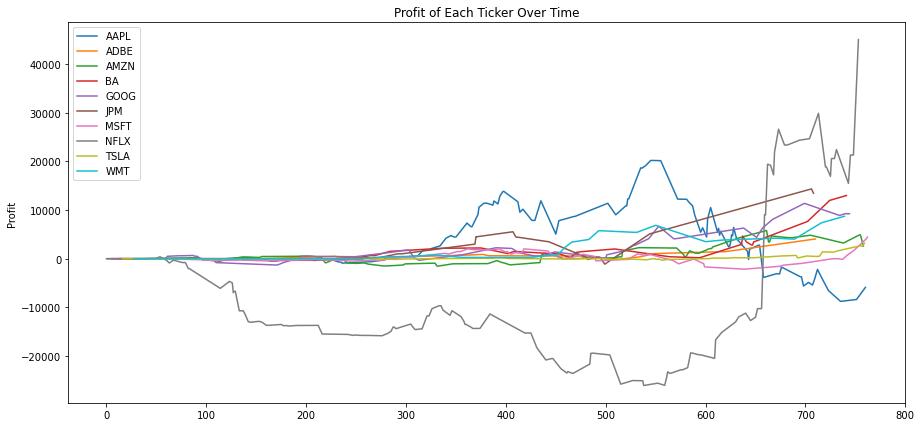

In [22]:
fig = plt.figure(figsize=(15, 7))
for ticker, group in df.groupby('ticker'):
    plt.plot(group['profit'],label=ticker)

# Set the plot title and axis labels

plt.title('Profit of Each Ticker Over Time')

plt.ylabel('Profit')

# Add the legend to the plot
plt.legend()

# Show the plot
plt.show()

In [23]:
# set another period
begin_date='2016-05-02'
end_date='2017-05-02'

In [30]:
strategy(0,-1,begin_date,end_date)[0].sum()

106239.53260040283

In [25]:
strategy(0,-1,begin_date,end_date)[1]

array([1000.,  400., 1400.,  800.,  600.,  300.,  300., 1300.,  900.,
        300.])

In [26]:
strategy(0,-1,begin_date,end_date)[2]

array([72534, 78814, 44524, 67575, 20239, 81124, 83625, 78313, -2136,
       64249])

In [27]:
df=strategy(0,-1,begin_date,end_date)[4]
df=df.reset_index(level=0,drop=True)

In [28]:
df[(df['ticker']=='TSLA')]

,ticker,headline,date,eventRet,Close,sentiment_lex,moving_avg,sentiment_diff,signal,profit,cash,position
2,TSLA,Analysts expect Tesla Motors (NASDAQ:TSLA) to ...,2016-05-03,-0.076897,15.488000,0.2780,16.680700,-0.4945,0,0.000000,100000,0
3,TSLA,John Hancock Financial is investing $227M in 2...,2016-05-03,-0.076897,15.488000,0.4673,16.680700,0.1893,0,0.000000,100000,0
6,TSLA,Tesla Motors (NASDAQ:TSLA) announces that it s...,2016-05-04,-0.130777,14.837333,-0.2479,16.537833,-0.7152,0,0.000000,100000,0
7,TSLA,Tesla (NASDAQ:TSLA): Q1 EPS of -$0.57 beats by...,2016-05-04,-0.130777,14.837333,0.0068,16.537833,0.2547,0,0.000000,100000,0
8,TSLA,SolarCity (SCTY) has nosedived in postmarket t...,2016-05-09,-0.012990,13.928000,0.3325,16.131800,0.3257,0,0.000000,100000,0
9,TSLA,In accord with SolarCity's post-earnings tumbl...,2016-05-10,-0.027770,13.912667,-0.4424,16.001367,-0.7749,0,0.000000,100000,0
13,TSLA,"The company launches a roughly-$2B secondary, ...",2016-05-18,0.033513,14.078000,0.7912,15.120867,1.2336,0,0.000000,100000,0
14,TSLA,Tesla Motors (NASDAQ:TSLA) is on the move in e...,2016-05-18,0.033513,14.078000,0.2352,15.120867,-0.5560,0,0.000000,100000,0
19,TSLA,"SolarCity (SCTY +8.9%), Vivint (VSLR +5.2%), a...",2016-05-23,0.012943,14.414667,0.7331,14.780367,0.4979,0,0.000000,100000,0
25,TSLA,Four days after SolarCity (SCTY +8.4%) officia...,2016-06-06,0.060691,14.712000,0.9650,14.347867,0.2319,1,-1.800011,98527,100


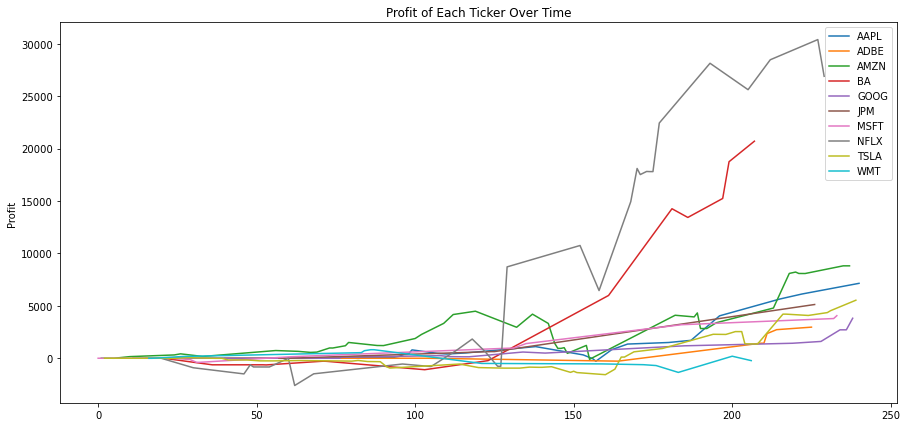

In [29]:
fig = plt.figure(figsize=(15, 7))
for ticker, group in df.groupby('ticker'):
    plt.plot(group['profit'],label=ticker)

# Set the plot title and axis labels

plt.title('Profit of Each Ticker Over Time')

plt.ylabel('Profit')

# Add the legend to the plot
plt.legend()

# Show the plot
plt.show()